In [2]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
import umap
from keybert import KeyBERT
import nltk
from nltk.corpus import stopwords
import spacy
import matplotlib.pyplot as plt

2025-05-22 11:03:09.515595: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747904589.540064   97415 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747904589.544083   97415 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747904589.556772   97415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747904589.556788   97415 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747904589.556790   97415 computation_placer.cc:177] computation placer alr

In [3]:
# Sample input
input_ideas = [
    "learn React", "JavaScript development", "jogging", "meditation", 
    "learn C#", "yoga", "run a marathon", "mindfulness", "backend development"
]

In [4]:
# Load spaCy model and stopwords
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words('english'))

In [5]:
# Preprocessing: lowercasing, removing stopwords, lemmatization
def preprocess(texts):
    processed = []
    for text in texts:
        doc = nlp(text.lower())
        tokens = [token.lemma_ for token in doc if token.lemma_ not in stop_words and token.is_alpha]
        processed.append(" ".join(tokens))
    return processed

processed_ideas = preprocess(input_ideas)

In [6]:

# Step 1: SBERT embeddings
model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = model.encode(processed_ideas)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [7]:
# Step 2: UMAP dimensionality reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

/home/montare/miniconda3/envs/ml-research-py310/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/montare/miniconda3/envs/ml-research-py310/lib/python3.10/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


In [8]:
# Step 3: KMeans clustering
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(embedding_2d)

In [9]:
# Step 4: Cluster labeling with KeyBERT
kw_model = KeyBERT(model=model)
cluster_texts = [[] for _ in range(n_clusters)]
for idx, label in enumerate(cluster_labels):
    cluster_texts[label].append(input_ideas[idx])

cluster_labels_text = []
for texts in cluster_texts:
    joined = ". ".join(texts)
    keywords = kw_model.extract_keywords(joined, keyphrase_ngram_range=(1, 2), stop_words='english', top_n=1)
    label = keywords[0][0] if keywords else "Cluster"
    cluster_labels_text.append(label)

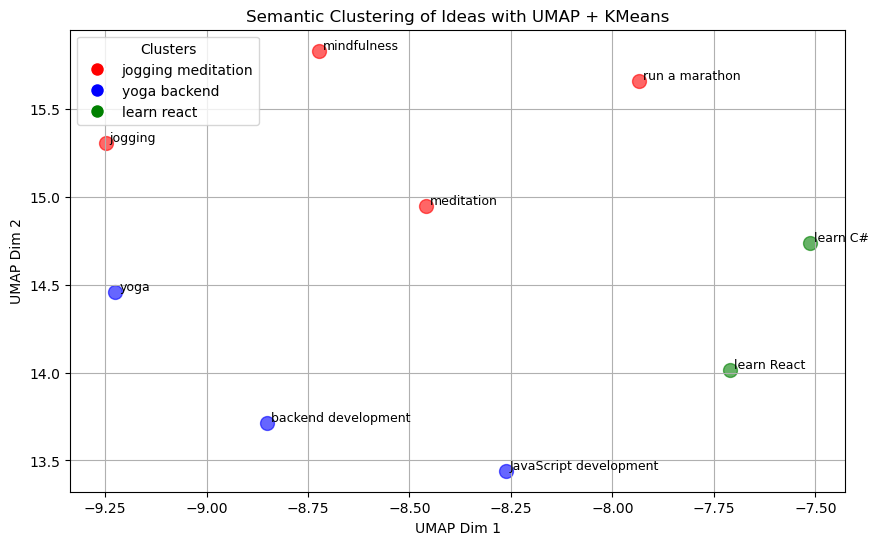

In [10]:

# Step 5: Simple 2D visualization
plt.figure(figsize=(10, 6))
colors = ['red', 'blue', 'green']
for i, (x, y) in enumerate(embedding_2d):
    label = cluster_labels[i]
    plt.scatter(x, y, color=colors[label], label=cluster_labels_text[label], s=100, alpha=0.6)
    plt.text(x + 0.01, y + 0.01, input_ideas[i], fontsize=9)

# Create legend with cluster labels
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, 
                      markerfacecolor=color, markersize=10) 
           for label, color in zip(cluster_labels_text, colors)]
plt.legend(handles=handles, title="Clusters", loc="best")
plt.title("Semantic Clustering of Ideas with UMAP + KMeans")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")
plt.grid(True)
plt.show()
